In [ ]:
import kagglehub
import os
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
try:
    path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")
    print("Path to dataset files:", path)
except Exception as e:
    print(f"Error downloading dataset: {e}")
    path = "brain-tumor-classification-mri"

100%|██████████| 86.8M/86.8M [00:00<00:00, 127MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


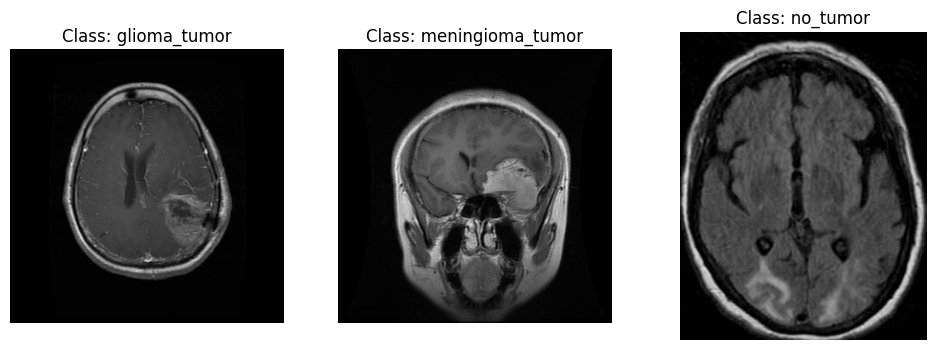

In [ ]:
# Display first 3 images and their classes

image_dir = os.path.join(path, "Training")
if not os.path.exists(image_dir):
  print(f"Error: Image directory not found at {image_dir}")
  exit()

classes = sorted(os.listdir(image_dir))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    try:
        class_dir = os.path.join(image_dir, classes[i])
        image_files = os.listdir(class_dir)

        if image_files:
            image_path = os.path.join(class_dir, image_files[0])

            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Class: {classes[i]}")
            axes[i].axis('off')
        else:
            print(f"No images found in directory: {class_dir}")

    except Exception as e:
        print(f"Error processing image {i}: {e}")


plt.show()

In [ ]:
data = {
    "train": os.path.join(path, "Training"),
    "test": os.path.join(path, "Testing")
}
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [ ]:
# Function to load data and resize images
def load_data(data_path, labels, img_size=224):
    X, y = [], []
    if not os.path.exists(data_path):
        raise ValueError(f"Error: Path not found -> {data_path}")

    for label in labels:
        label_path = os.path.join(data_path, label)
        if not os.path.exists(label_path):
            print(f"Warning: Folder not found for label '{label}', skipping.")
            continue

        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: '{img_name}' could not be read, skipping.")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(labels.index(label))
            except Exception as e:
                print(f"Warning: Error loading '{img_name}': {e}")

    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = load_data(data["train"], labels)
X_test, y_test = load_data(data["test"], labels)

In [ ]:
# Ensure 'labels' is defined
labels = ["glioma", "meningioma", "pituitary", "notumor"]
num_classes = len(labels)

# Normalize the data
X_train, X_test = X_train.astype("float32") / 255.0, X_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train, y_test = to_categorical(y_train, num_classes), to_categorical(y_test, num_classes)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

In [ ]:
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Regularization
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,428,036 (74.11 MB)

 Trainable params: 19,428,036 (74.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3205 - loss: 1.3405 - val_accuracy: 0.5279 - val_loss: 1.0796
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 218ms/step - accuracy: 0.5508 - loss: 1.0190 - val_accuracy: 0.6237 - val_loss: 0.8290
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.6514 - loss: 0.8083 - val_accuracy: 0.6864 - val_loss: 0.6867
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.7212 - loss: 0.6471 - val_accuracy: 0.7003 - val_loss: 0.6585
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.7637 - loss: 0.5385 - val_accuracy: 0.7474 - val_loss: 0.5401
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.8355 - loss: 0.4065 - val_accuracy: 0.8049 - val_loss: 0.4857
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.8684 - loss: 0.3592 - val_accuracy: 0.7927 - val_loss: 0.5246
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.8929 - loss: 0.2514 - val_accuracy: 0.8

In [ ]:
def predict_image(image_path, model):
  """
  Predicts the class of an image using the provided model.

  Args:
    image_path: Path to the image file.
    model: The trained Keras model.

  Returns:
    A string representing the predicted class label.
  """
  try:
    img = cv2.imread(image_path)
    if img is None:
      print(f"Error: Could not read image at {image_path}")
      return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    predictions = model.predict(img)
    predicted_class_index = np.argmax(predictions)
    labels = ["glioma", "meningioma", "pituitary", "notumor"]
    predicted_class = labels[predicted_class_index]
    return predicted_class
  except Exception as e:
    print(f"Error during prediction: {e}")
    return None


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.7771 - loss: 1.7906
Test Loss: 3.8036
Test Accuracy: 0.6371


In [ ]:
# Confusion Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


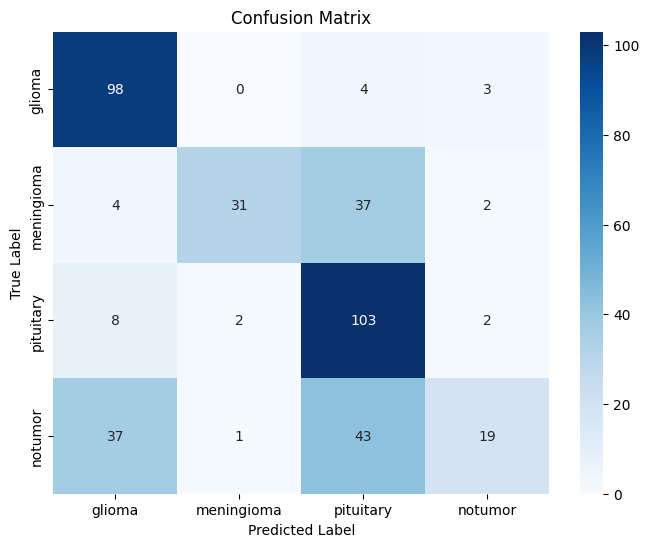

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

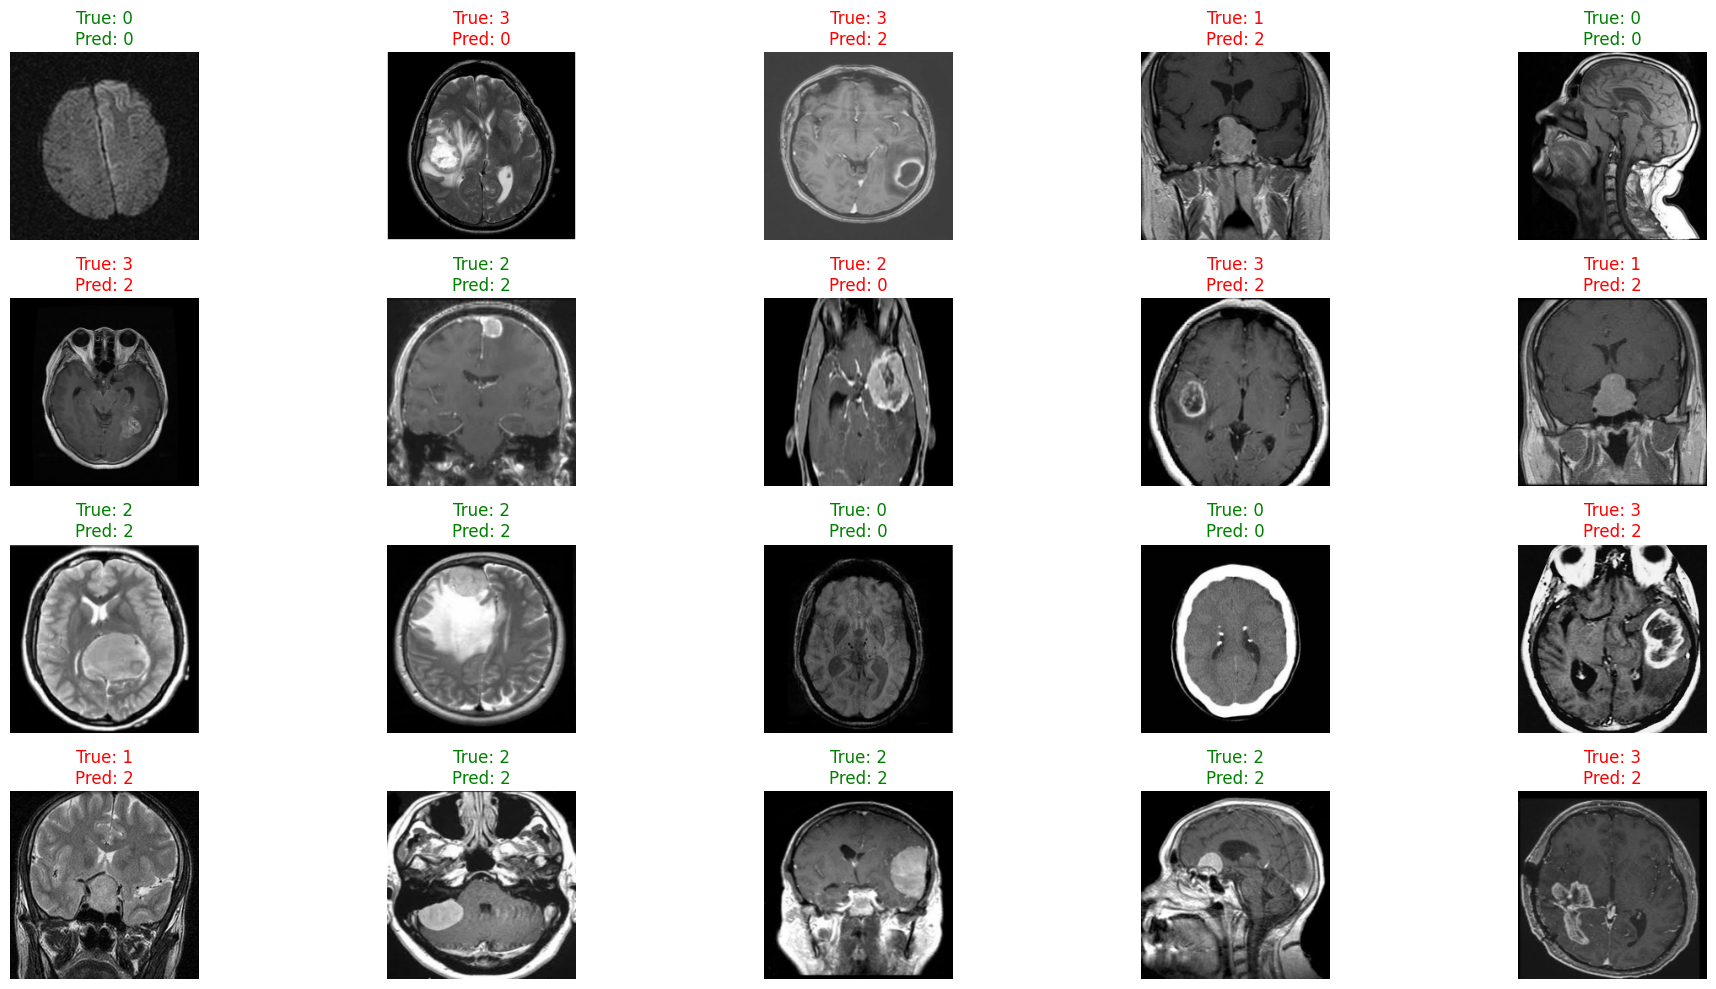

In [ ]:
random_indices = np.random.choice(len(X_test), 20, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label = y_true[idx]
    pred_label = y_pred_classes[idx]

    plt.subplot(4, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

plt.tight_layout()
plt.show()